In [ ]:
#default_exp vision.timm

# Utilizing the `timm` Library Inside of `fastai` (Intermediate)

> How to bring the power of Transfer Learning with new architectures

In [ ]:
#hide
from wwf.utils import *
from nbdev.showdoc import *

In [ ]:
#hide_input
state_versions(['fastai', 'fastcore', 'timm'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, and `timm` currently running at the time of writing this:
* `fastai` : 2.3.0 
* `fastcore` : 1.3.20 
* `timm` : 0.4.5 
---

## Bringing in External Models into the Framework

As we are well aware, `fastai` models deep down are just `PyTorch` models. However as the field of Machine Learning keeps going, new and fresh architectures are introduced. Wouldn't it be nice if it were easy to integrate them into the `fastai` framework and play with them?

## Using Ross Wightman's `timm` Library

[Ross Wightman](https://twitter.com/wightmanr) has been on a mission to get pretrained weights for the newest Computer Vision models that come out of papers, and compare his results what the papers state themselves. The fantastic results live in his repository [here](https://github.com/rwightman/pytorch-image-models)

For users of the `fastai` library, it is a goldmine of models to play with! But how do we use it? Let's set up a basic `PETs` problem following the [tutorial](https://walkwithfastai.com/vision.clas.single_label):

In [ ]:
#export
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.PETS)
pat = r'/([^/]+)_\d+.*'
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=16
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(0.2),
                 get_y=RegexLabeller(pat = pat),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)
dls = pets.dataloaders(path/'images', bs=bs)

From here we would normally do something like `cnn_learner(dls, arch, metrics)`, however we need to do a few things special to work with Ross' framework.

`fastai` has a `create_body` function, which is called during `cnn_learner`, that will take a model architecuture and slice off the last Linear layer (resulting in a "body" that outputs unpooled features). This function looks like:

In [ ]:
def create_body(arch, n_in=3, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained `arch` as determined by `cut`"
    model = arch(pretrained=pretrained)
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int):      return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else:                           raise NamedError("cut must be either integer or a function")

We're going to create our own that plays well
> Also: notebooks like this are exported as external modules inside of the `wwf` library! This one can be found in `vision.timm` to be used with your projects!

In [ ]:
#export
from timm import create_model
from fastai.vision.learner import _update_first_layer

In [ ]:
#exports
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

How do we use it? Let's try it out on an `efficientnet_b3` architecture (the entire list of supported architectures is found [here](https://github.com/rwightman/pytorch-image-models#models)

In [ ]:
body = create_timm_body('efficientnet_b3a', pretrained=True)

From here we can calculate the number input features our head needs to have with `num_features_model`.  We can pass `concat_pool=True` to have fastai create a head with two pooling layers: `AdaptiveConcatPool2d` and `nn.AdaptiveAvgPool2d`

In [ ]:
nf = num_features_model(body); nf

1536

And now we can create a head!


In [ ]:
head = create_head(nf, dls.c, concat_pool=True)

To mix them together, we just wrap the two in a `nn.Sequential` and we now have a `PyTorch` model ready to be trained on:

In [ ]:
net = nn.Sequential(body, head)

From here we would pass it onto `Learner`, specifying our `splitter` to be the `default_split`
> `default_splitter` expects the body in `model[0]` and the head in `model[1]` to split our layer groups

In [ ]:
learn = Learner(dls, net, splitter=default_split)

To know this all worked properly, we should be able to call `learn.freeze()` and check the number of frozen parameters. (You can also call `learn.summary` but we are not since it has a lengthy output):

In [ ]:
learn.freeze()
frozen = filter(lambda p: not p.requires_grad, learn.model.parameters())
frozen = sum([np.prod(p.size()) for p in frozen])
model_parameters = filter(lambda p: p.requires_grad, learn.model.parameters())
unfrozen = sum([np.prod(p.size()) for p in model_parameters])

In [ ]:
frozen, unfrozen

(10608936, 1686272)

Which we can see that only 1.6 million of the 10 million parameters are trainable, so our model is ready for transfer learning!

## Turning it all into a function

Let's make this a bit easier and create something like `cnn_learner`, but for `timm`! We'll call it a `timm_learner`. First let's look at and compare what `cnn_learner` does internally:

In [ ]:
def cnn_learner(dls, arch, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch`"
    if config is None: config = {}
    meta = model_meta.get(arch, _default_meta)
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if normalize: _add_norm(dls, meta, pretrained)
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_cnn_model(arch, n_out, ifnone(cut, meta['cut']), pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=ifnone(splitter, meta['split']), **kwargs)
    if pretrained: learn.freeze()
    return learn

At first it looks scary, but let's try and read it as best we can:
1. Grab potential private meta about an architecture we're using
2. Grab the number of expected outputs
3. Potentially normalize
4. Add a `y_range`
5. Create a `cnn_model` and `Learner`
6. Freeze our model

We're going to make a custom `create_timm_model` and `timm_learner` function to do what we just did above. First, `create_timm_model` will model after `create_cnn_model`:

In [ ]:
#exports
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

And now for our `timm_learner`:

In [ ]:
#export
from fastai.vision.learner import _add_norm

In [ ]:
#exports
def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

Let's try it out by making the same model we did a moment ago:

In [ ]:
learn = timm_learner(dls, 'efficientnet_b3a')

And to verify let's look at those parameters one more time:

In [ ]:
frozen = filter(lambda p: not p.requires_grad, learn.model.parameters())
frozen = sum([np.prod(p.size()) for p in frozen])
model_parameters = filter(lambda p: p.requires_grad, learn.model.parameters())
unfrozen = sum([np.prod(p.size()) for p in model_parameters])

In [ ]:
frozen, unfrozen

(10608936, 1686272)

They're exactly the same! So now we can utilize any architecture found inside of `timm` right away, and we built it in a structure very similar to how native `fastai` does it. 

To use this module in your own work, simply do:
```python
from wwf.vision.timm import *
learn = timm_learner(dls, 'efficientnet_b3a', metrics=[error_rate, accuracy])
```

> Note: `timm` needs to be installed beforehand

## Model Lookup

To query various models to see what is available, you should directly use the `timm` library.


In [ ]:
import timm

### Listing all models available

One option is to list every model possible:

In [ ]:
timm.list_models()[:10]

['adv_inception_v3',
 'cspdarknet53',
 'cspdarknet53_iabn',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'cspresnext50_iabn',
 'darknet53',
 'densenet121']

### Searching for models

You can also query the names of what is available as well, denoted as below:

In [ ]:
timm.list_models('*efficientnet*')[:10]

['efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4']

In [ ]:
timm.list_models('*b3a')[:10]

['efficientnet_b3a']

In [ ]:
timm.list_models('resne*t*', pretrained=True)[:10]

['resnest14d',
 'resnest26d',
 'resnest50d',
 'resnest50d_1s4x24d',
 'resnest50d_4s2x40d',
 'resnest101e',
 'resnest200e',
 'resnest269e',
 'resnet18',
 'resnet18d']

## Some Warnings

* Watch for anything with a `tf_` prefix. This means the original weights were ported from Google, so it uses manual padding to match TensorFlow's "same" padding, which adds GPU overhead and a general slowdown. If possible try to use the non-TF versions of models

* HRNet is a bit of a problem-child, so it is the only one not straight-forward to use

## Unet integration

(This section is a submission by Dom Miketa.)

Many of the networks included in `timm` enjoy a second life as "backbones" for [Unets](https://arxiv.org/abs/1505.04597), a popular architecture for segmentation ("is there a pedestrian at this pixel?") and similar vision tasks whose outputs have the same height and width as their corresponding inputs. A Unet consists of an encoder – structurally very similar to a headless classifier – and a decoder whose main role is to upscale and refine the encoder output. But there is a twist: the decoder also looks at features computed partway along the encoder. So we first need to get the encoder to output a *sequence* of features computed at various scales. Fortunately `timm` can do that for us: we only need to call `create_model` with the optional argument `features_only=True`. The rest is a bit more work.

We roughly follow the structure and settings of `DynamicUnet` in `fastai`, also taking inspiration from Ross Wightman's prototype [Unet code](https://gist.github.com/rwightman/f8b24f4e6f5504aba03e999e02460d31).

The encoder is fully provided by `timm`, so the next step is to build a decoder which can accept multiple inputs at various scales. We will build it from standardised blocks. It is common practice to imbue the Unet with a "bottleneck" layer at the bottom of the "U", and we will integrate it into the decoder itself. You can pass it a string (`'conv'`, `'attention'` or `'double_attention'`), a `Module` or nothing and it'll work as expected.

In [ ]:
#exports
class DecoderBlock(Module):
    """
    Decoder Block based off https://gist.github.com/rwightman/f8b24f4e6f5504aba03e999e02460d31
    """
    def __init__(self, up_in_c, s_in_c, scale=2, blur=False,  final_div=True,
                 act_cls=defaults.activation, init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, scale=scale, blur=blur, act_cls=act_cls, norm_type=norm_type, **kwargs)
        self.bn = BatchNorm(s_in_c)
        self.act = act_cls()
        ni = up_in_c//2 + s_in_c
        nf = ni if final_div else ni//2
        self.nf = nf
        self.conv1 = ConvLayer(ni, nf, act_cls=act_cls, norm_type=norm_type, **kwargs)
        self.conv2 = ConvLayer(nf, nf, act_cls=act_cls, norm_type=norm_type, **kwargs)
        apply_init(nn.Sequential(self.shuf, self.bn, self.conv1, self.conv2), init)

    def forward(self, up_in: torch.Tensor, skip: Optional[torch.Tensor] = None):
        x = self.shuf(up_in)
        if skip is not None:
            ssh = skip.shape[-2:]
            if ssh != x.shape[-2:]:
                x = F.interpolate(x, ssh, mode='nearest')
            x = self.act(torch.cat([x, self.bn(skip)], dim=1))
        return self.conv2(self.conv1(x))

In [ ]:
#exports
@delegates(nn.BatchNorm2d)
def BatchNormZero(nf, ndim=2, **kwargs):
    "BatchNorm layer with `nf` features and `ndim` initialized depending on `norm_type`. Weights initialized to zero."
    return _get_norm('BatchNorm', nf, ndim, zero=True, **kwargs)


def _make_bottleneck(bottleneck, ni, act_cls=defaults.activation, norm_type=None, init=nn.init.kaiming_normal_, **kwargs):
    if bottleneck == 'conv':
        seq = nn.Sequential(BatchNorm(ni), nn.ReLU(),
                            ConvLayer(ni, ni*2, act_cls=act_cls, norm_type=norm_type, **kwargs),
                            ConvLayer(ni*2, ni, act_cls=act_cls, norm_type=norm_type, **kwargs))
    elif bottleneck == 'attention':
        seq = nn.Sequential(BatchNormZero(ni), nn.ReLU(),
                            ConvLayer(ni, ni, act_cls=act_cls, norm_type=norm_type, **kwargs),
                            SimpleSelfAttention(ni, ks=1))
    elif bottleneck == 'double_attention':
        seq = nn.Sequential(BatchNormZero(ni), nn.ReLU(),
                            ConvLayer(ni, ni, act_cls=act_cls, norm_type=norm_type, **kwargs),
                            SimpleSelfAttention(ni, ks=1),
                            ConvLayer(ni, ni, act_cls=act_cls, norm_type=norm_type, **kwargs),
                            SimpleSelfAttention(ni, ks=1))
    else: raise NotImplementedError(f'Bottleneck architecture {bottleneck} not implemented.')
    apply_init(seq, init)
    return seq

In [ ]:
#export
from typing import List

In [ ]:
#exports
class UnetDecoder(Module):
    """
    Unet Decoder  based off https://gist.github.com/rwightman/f8b24f4e6f5504aba03e999e02460d31
    """
    def __init__(self, encoder, bottleneck=None, blur=False, blur_final=True,
                 norm_type=None, act_cls=defaults.activation, init=nn.init.kaiming_normal_, **kwargs):
        

        encoder_chs = encoder.feature_info.channels()[::-1]
        encoder_reds = encoder.feature_info.reduction()
        skip_channels = L(encoder_chs[1:])

        self.blocks = nn.ModuleList()
        up_c = encoder_chs[0]
        self.bottleneck = _make_bottleneck(bottleneck, up_c, act_cls=act_cls, norm_type=norm_type, init=init, **kwargs) if isinstance(bottleneck,str) else bottleneck
        for i,skip_c in enumerate(skip_channels):
            not_final = i!=len(skip_channels)-1
            do_blur = blur and (not_final or blur_final)
            scale = encoder_reds.pop()//encoder_reds[-1]
            block = DecoderBlock(up_c, skip_c, scale=scale, blur=do_blur, final_div=not_final, act_cls=act_cls, init=init, norm_type=norm_type, **kwargs)
            up_c = block.nf
            self.blocks.append(block)

        scale = encoder_reds[0]
        self.final_shuf = PixelShuffle_ICNR(up_c, scale=scale, act_cls=act_cls, norm_type=norm_type, **kwargs) if scale!= 1 else None
        self.nf = up_c

    def forward(self, x: List[torch.Tensor]):
        x.reverse()  # torchscript doesn't work with [::-1]
        skips = x[1:]
        x = x[0]
        if self.bottleneck is not None: x = self.bottleneck(x)
        for i, b in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = b(x, skip)
        if self.final_shuf is not None: x = self.final_shuf(x)
        return x

The Unet also needs its head, the final sequence of layers:

In [ ]:
#exports
class UnetHead(SequentialEx):
    "Head of a Unet Model"
    def __init__(self, up_c, n_out, last_cross=False, n_in=None, bottle=False, norm_type=None, act_cls=defaults.activation, init=nn.init.kaiming_normal_, y_range=None, **kwargs):
        layers = nn.ModuleList([ResizeToOrig()])
        if last_cross:
            if n_in is None: raise AttributeError('You must specify `n_in` if `last_cross=True`.')
            up_c += n_in
            layers.extend([MergeLayer(dense=True), ResBlock(1, up_c, up_c//2 if bottle else up_c, act_cls=act_cls, norm_type=norm_type, **kwargs)])
        layers.append(nn.Conv2d(up_c, n_out, kernel_size=(1, 1)))
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)
        apply_init(self, init)

Now we can combine them all together into a Unet.

In [ ]:
#exports
class TimmUnet(SequentialEx):
    """
    Unet is a fully convolution neural network for image semantic segmentation
    
    Args:
        - `encoder`: name of classification model (without last dense layers) used as feature
            extractor to build segmentation model.
        - `n_in`: number of input channels.
        - `n_out`: number of output_channels
        - `encoder_kwargs`: kwargs for the encoder
        - `encoder_indices`: indices of layers at which encoder features are extracted.
        - `blur`: use blur inside PixelShuffle_ICNR.
        - `blur_final`: use blur inside the final decoder block.
        - `bottleneck`: one of 'conv' (two conv blocks), 'attention' (conv block followed by SimpleSelfAttention),
            'double_attention' (like 'attention' but twice in series).
        - `last_cross`: concatenate input before final layers.
        - `pretrained`: use pretrained weights in the encoder.
        - `y_range`: attach a scaled sigmoid layer to the end.
        - `bottle`: bottleneck structure in the final ResBlock layer (if last_cross).
    """

    def __init__(self, encoder='resnet50', n_in=3, n_out=1, encoder_kwargs=None, encoder_indices=None,
                 blur=False, blur_final=True,
                 bottleneck=None, last_cross=True, norm_type=None, act_cls=defaults.activation,
                 init=nn.init.kaiming_normal_, pretrained=True, y_range=None, bottle=False, **kwargs):
        encoder_kwargs = encoder_kwargs or {}
        # NOTE some models need different backbone indices specified based on the alignment of features
        # and some models won't have a full enough range of feature strides to work properly.
        self.encoder = create_model(encoder, features_only=True, out_indices=encoder_indices, in_chans=n_in,
                                    pretrained=pretrained, **encoder_kwargs)

        self.decoder = UnetDecoder(self.encoder, bottleneck=bottleneck, blur=blur, blur_final=blur_final,
                                   norm_type=norm_type, act_cls=act_cls, init=init, **kwargs)

        self.head = UnetHead(self.decoder.nf, n_out, last_cross=last_cross, n_in=n_in, bottle=bottle,
                             norm_type=norm_type, act_cls=act_cls, init=init, y_range=y_range, **kwargs)
        super().__init__(nn.Sequential(self.encoder, self.decoder), *self.head)

    @property
    def default_cfg(self): return self.encoder.default_cfg
    @property
    def feature_info(self): return self.encoder.feature_info

Next we need to write some configurations, or `splitters`. These help our differential learning rates know what groups of layers apply to what learning rate passed through our optimizer and during fit. The slowest learning rate should be assigned to that part of the model which sits closest to the input. `timm` provides a function which identifies the first "stage" by name, and we can use it to build a heuristic `_timm_splitter`: modules before the first named module (`blocks.0.1`, resp. `act1`) are "early", and those after (and including the named module) are "late". 

In [ ]:
enc1 = create_model('efficientnet_b1', features_only=True)
enc2 = create_model('resnet34', features_only=True)

print(f'efficientnet_b1: {enc1.feature_info.info}')
print(f'resnet34: {enc2.feature_info.info}')

efficientnet_b1: [{'stage': 1, 'reduction': 2, 'module': 'blocks.0.1', 'hook_type': '', 'num_chs': 16}, {'stage': 2, 'reduction': 4, 'module': 'blocks.1.2', 'hook_type': '', 'num_chs': 24}, {'stage': 3, 'reduction': 8, 'module': 'blocks.2.2', 'hook_type': '', 'num_chs': 40}, {'stage': 5, 'reduction': 16, 'module': 'blocks.4.3', 'hook_type': '', 'num_chs': 112}, {'stage': 7, 'reduction': 32, 'module': 'blocks.6.1', 'hook_type': '', 'num_chs': 320}]
resnet34: [{'num_chs': 64, 'reduction': 2, 'module': 'act1'}, {'num_chs': 64, 'reduction': 4, 'module': 'layer1'}, {'num_chs': 128, 'reduction': 8, 'module': 'layer2'}, {'num_chs': 256, 'reduction': 16, 'module': 'layer3'}, {'num_chs': 512, 'reduction': 32, 'module': 'layer4'}]


In [ ]:
#exports
def _get_params_from_attrs(m, ls): return params(nn.Sequential(*getattrs(m, *ls)))
def _get_params_from_modules(modules): return params(nn.Sequential(*modules))

def split_nested_list(l, idxs, left_in=None, right_in=None):
    left_in,right_in = ifnone(left_in,L()),ifnone(right_in,L())
    idx = int(idxs[0])
    if len(idxs)==1: left,right = l[:idx],l[idx:]
    else: left,right = split_nested_list(l[idx], idxs[1:], l[:idx], l[idx+1:])
    return L(L(*left_in,*left), L(*right,*right_in))

def _timm_splitter(m):
    encoder_module_names = L(m.encoder._modules)
    encoder_split_idxs = m.feature_info.module_name(0).split('.')
    # the first idx is a (unique) name so we convert it to a numerical idx
    encoder_split_idxs[0] = encoder_module_names.index(encoder_split_idxs[0])
    encoder_modules = getattrs(m.encoder,*encoder_module_names)
    encoder_early,encoder_late = split_nested_list(encoder_modules,encoder_split_idxs)
    encoder_early = _get_params_from_modules(encoder_early)
    encoder_late = _get_params_from_modules(encoder_late)
    decoder = _get_params_from_attrs(m.decoder, L(m.decoder._modules))
    head = _get_params_from_attrs(m.head, L(m.head._modules))
    return L(encoder_early, encoder_late, L(*decoder, *head))

Next, each model comes carrying some metadata about the mean and standard deviation of the dataset, and the indices of the early, middle, and late layers. We'll write a convience `_timm_stats` function to grab it:

In [ ]:
#export
def _timm_stats(m): return tuple((list(m.default_cfg[stat]) for stat in ('mean','std')))

All that remains is to define an appropriate `Learner` factory function, similar to fastai's `unet_learner`:

In [ ]:
#export
@delegates(TimmUnet.__init__)
def timm_unet_learner(dls, arch, normalize=True, n_in=None, n_out=None, pretrained=True,
                 # learner args
                 loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
                 model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
                 # other model args
                 bottleneck='conv',
                 **kwargs):
    "Build a Unet learner with a timm backbone from `dls` and `arch`"

    n_in = ifnone(n_in, dls.one_batch()[0].shape[1])
    n_out = ifnone(n_out, get_c(dls))
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    model = TimmUnet(arch, n_in=n_in, n_out=n_out, pretrained=pretrained, bottleneck=bottleneck, **kwargs)

    if normalize: _add_norm(dls, {'stats': _timm_stats(model)}, pretrained)
    splitter=ifnone(splitter, _timm_splitter)
    learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
                   metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn,
                   moms=moms)
    if pretrained: learn.freeze()
    # keep track of args for loggers
    store_attr('arch,normalize,n_out,pretrained', self=learn, **kwargs)
    return learn

Let's try it out on a simple example: CAMVID as covered in the very first chapter of [the fastai book](https://github.com/fastai/fastbook/blob/master/01_intro.ipynb).

epoch,train_loss,valid_loss,time
0,3.138450,2.077076,00:02


epoch,train_loss,valid_loss,time
0,1.836998,1.696764,00:02
1,1.672351,1.476891,00:01
2,1.574407,1.391795,00:01
3,1.456081,1.293011,00:02
4,1.356063,1.190900,00:02
5,1.260558,1.124920,00:01
6,1.177755,1.093393,00:01
7,1.111715,1.079986,00:01


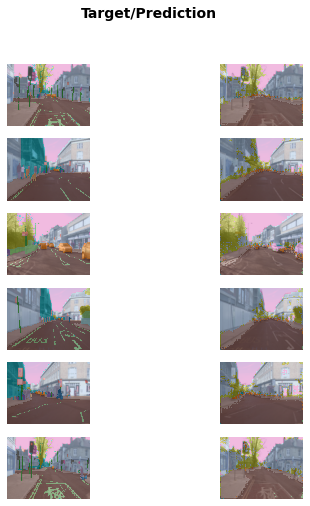

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str))

learn = timm_unet_learner(dls, 'efficientnet_b1')
learn.fine_tune(8)
learn.show_results(max_n=6, figsize=(7,8))